In [122]:
# Google Drive マウント
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML
data/                logs/           model/        Untitled0.ipynb
DeadReckoning.ipynb  makedata.ipynb  others/
graph/               ML_angle.ipynb  __pycache__/
loaddata.ipynb       ML.ipynb        scripts/


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import sys
sys.path.append('/content/drive/My Drive/卒業研究'
                '/DeadReckoning_ExperimentalData/ML/scripts')
import loaddata as ld

In [0]:
def calc_distance(x1, y1, x2, y2):
    dx = x1 - x2
    dy = y1 - y2
    distance = np.sqrt(dx**2 + dy**2)
    return distance

Index(['acc_linearX[m/s^2]', 'acc_linearY[m/s^2]', 'acc_linearZ[m/s^2]',
       'accX[m/s^2]', 'accY[m/s^2]', 'accZ[m/s^2]', 'gyroX[rad/s]',
       'gyroY[rad/s]', 'gyroZ[rad/s]', 'angleX[rad]', 'angleY[rad]',
       'angleZ[rad]', 'step', 'angleX[deg]', 'angleY[deg]', 'angleZ[deg]',
       'gyroX[deg/s]', 'gyroY[deg/s]', 'gyroZ[deg/s]', 'angleX[rad/s]',
       'angleY[rad/s]', 'angleZ[rad/s]', 'angleX[deg/s]', 'angleY[deg/s]',
       'angleZ[deg/s]'],
      dtype='object')
Index(['latitude(deg)', 'longitude(deg)', 'speed[m/s]', 'angle[rad]',
       'omega[rad/s]', 'x', 'y', 'speed_1Hz[m/s]', 'omega_1Hz[rad/s]',
       'angle[deg]', 'omega[deg/s]', 'omega_1Hz[deg/s]'],
      dtype='object')


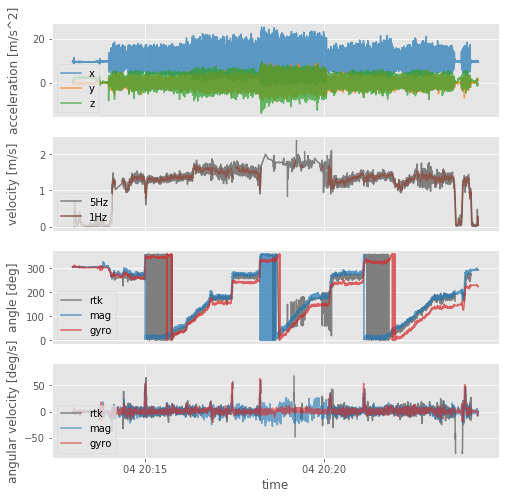

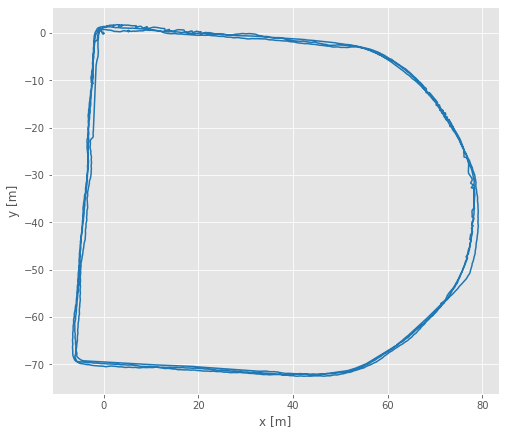

In [125]:
directorys = ['data/191106_1152',
              'data/191121_1625',
              'data/191204_1956',
              'data/191204_2012',
              'data/191211_1649',
              'data/200116_1104',
              'data/200116_1121']
directory = directorys[3]

# データ読み込み
df_acc = ld.loadAccData(directory+'/acc.csv')
df_rtk = ld.loadRTKData(directory+'/rtk.csv')
df_acc, df_rtk = ld.fitData(df_acc, df_rtk)

plt.rcParams['font.size'] = 10
ld.plot(df_acc, df_rtk)

print(df_acc.keys())
print(df_rtk.keys())

In [0]:
# GPSデータの読み込み
# df_gps = ld.loadGPSData(directory+'/gps.csv',
#                         df_rtk['latitude(deg)'][0],
#                         df_rtk['longitude(deg)'][0])
# df_gps = df_gps[df_acc.index[0]:]
# print(df_gps.keys())

In [127]:
from tensorflow import keras

def speed_estimation(modelfilename, df_acc):
    model = keras.models.load_model(modelfilename)

    acc_list = []
    for t in tqdm(range(50, df_acc.shape[0])):
        acc_x = df_acc['accX[m/s^2]'][t-50 : t]
        acc_y = df_acc['accY[m/s^2]'][t-50 : t]
        acc_z = df_acc['accZ[m/s^2]'][t-50 : t]
        acc = np.concatenate([acc_x, acc_y, acc_z])
        acc /= 9.8
        acc_list.append(acc)

    acc_list = np.array(acc_list)
    speed = model.predict(acc_list)
    speed = np.reshape(speed, speed.shape[0])
    speed = np.concatenate([[0.0 for i in range(50)], speed])
    df_acc['speed[m/s]'] = speed

# 歩幅推定
speed_estimation('model/my_model.h5', df_acc)

100%|██████████| 33851/33851 [00:27<00:00, 1251.40it/s]


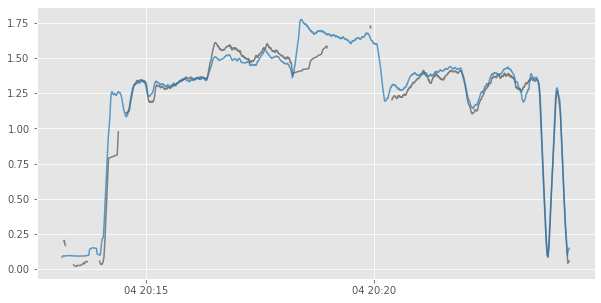

In [128]:
plt.figure(figsize=(10, 5))
plt.plot(df_rtk['speed[m/s]'].rolling(50).mean(), color='tab:gray')
plt.plot(df_acc['speed[m/s]'].rolling(500).mean(), color='tab:blue', alpha=0.7)

In [0]:
# 相補フィルター
def complementary_filter(df_acc):
    C = 0.99
    angle_list = [0.0]
    for t in df_acc.index[1:]:
        dt = 0.02
        gyro = angle_list[-1] + df_acc['gyroX[deg/s]'][t] * dt
        mag = df_acc['angleZ[deg]'][t]
        angle = C * gyro + (1-C) * mag
        angle %= 360
        angle_list.append(angle)
    angle_list = np.array(angle_list)
    return angle_list

angle_list = complementary_filter(df_acc)

In [0]:
# 方向推定
def direction_estimation(df_acc):
    offset = -0.10210938504840368 * np.pi/180
    gyroX = (df_acc['gyroX[rad/s]'] - offset).cumsum() * 0.02
    gyroX += df_acc['angleZ[rad]'][0]
    gyroX %= 2*np.pi
    df_acc['gyroX[rad]'] = gyroX

direction_estimation(df_acc)

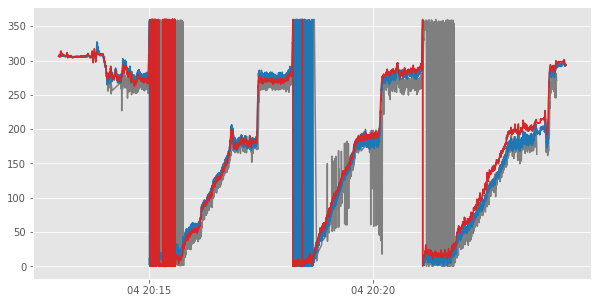

In [131]:
plt.figure(figsize=(10, 5))
plt.plot(df_rtk['angle[deg]'], color='tab:gray')
plt.plot(df_acc['angleZ[deg]'], color='tab:blue')
plt.plot(df_acc['gyroX[rad]'] * 180/np.pi, color='tab:red')

# 相補フィルター
# plt.plot(df_acc.index, angle_list, color='tab:orange', alpha=1.0)

In [0]:
def step_estimation(df_acc):
    accX = df_acc['accX[m/s^2]']
    accY = df_acc['accY[m/s^2]']
    accZ = df_acc['accZ[m/s^2]']
    acc_norm = np.sqrt(accX**2 + accY**2 + accZ**2)
    acc_norm = acc_norm.rolling(5).mean()
    acc_norm = acc_norm / 9.8 - 1

    step_list = []
    acc_old = acc_norm[0]
    for acc in acc_norm:
        step = 0
        g = 0.2
        if acc_old < g and acc > g: step = 1
        acc_old = acc
        step_list.append(step)
    df_acc['step'] = step_list

# 歩数推定
step_estimation(df_acc)

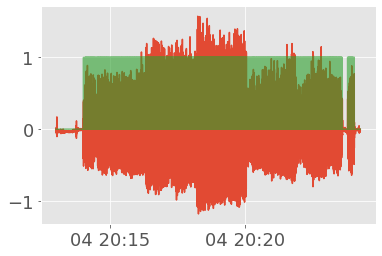

In [156]:
plt.plot(df_acc['accX[m/s^2]']/9.8-1)
plt.plot(df_acc['step'], color='tab:green', alpha=0.6)

In [0]:
import datetime

def DeadReckoning(df_acc, df_rtk, locs):
    X_mag, Y_mag, X_gyro, Y_gyro = [0.0], [0.0], [0.0], [0.0]
    last_t = df_rtk.index[0]
    last_flag = False

    t = df_rtk.index[0]
    datetime_list = [t]
    dt = 0.2
    num = (df_acc.index[-1] - df_acc.index[0]).total_seconds() / dt
    for i in tqdm(range(int(num))):
        t += datetime.timedelta(seconds=dt)
        datetime_list.append(t)
        df_acc_part = df_acc[:t]
        df_rtk_part = df_rtk[:t]

        if df_acc_part['step'][-1] == df_acc_part['step'][-2]:
            X_mag.append( X_mag[-1])
            Y_mag.append( Y_mag[-1])
            X_gyro.append(X_gyro[-1])
            Y_gyro.append(Y_gyro[-1])
            continue

        # 指定位置に達した場合の位置補正
        flag = False
        for loc in locs:
            distance = calc_distance(df_rtk_part['x'][-1],
                                     df_rtk_part['y'][-1], loc[0], loc[1])
            if distance < 0.3:
                flag = True
                nowloc = loc

            if last_flag == True and flag == False:
                direction_gyro = np.median(df_rtk_part['angle[rad]'][-1])
                X_mag.append(nowloc[0])
                Y_mag.append(nowloc[1])
                X_gyro.append(nowloc[0])
                Y_gyro.append(nowloc[1])
                break
    
        # 位置更新
        else:
            stride = df_acc_part['speed[m/s]'][-1] * dt
            stride = df_acc_part['speed[m/s]'][-1]
            mag = df_acc_part['angleZ[rad]'][-1]
            gyro = df_acc_part['gyroX[rad]'][-1]
            X_mag.append( X_mag[-1]  + stride * np.cos(mag))
            Y_mag.append( Y_mag[-1]  + stride * np.sin(mag))
            X_gyro.append(X_gyro[-1] + stride * np.cos(gyro))
            Y_gyro.append(Y_gyro[-1] + stride * np.sin(gyro))

        last_t = t
        last_flag = flag

    # データフレーム生成
    df_dr = pd.DataFrame({'datetime': datetime_list,
                          'x_mag': X_mag,
                          'y_mag': Y_mag,
                          'x_gyro': X_gyro,
                          'y_gyro': Y_gyro})
    df_dr['datetime'] = pd.to_datetime(df_dr['datetime'])
    df_dr.set_index('datetime', inplace=True)

    return df_dr

In [0]:
# 修正ポイント
# locs = np.array([[-2.6, -35.0], [79.1, -35.0], [40.0, -1.8], [40.0, -72.1]])
# locs = np.array([[-2.5, -35.0], [79.0, -35.0]])
# locs = np.array([[79.0, -35.0]])
# locs = np.array([[-9.9, -4.0]])
locs = np.array([])

In [167]:
# デッドレコニングシミュレーション
df_dr = DeadReckoning(df_acc, df_rtk, locs)

100%|██████████| 3389/3389 [00:05<00:00, 666.01it/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


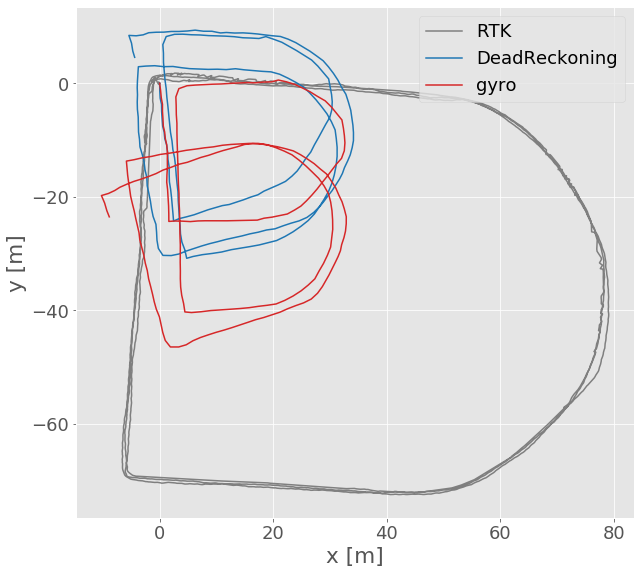

In [168]:
def plot_result():
    fig = plt.figure(figsize=(10, 10))
    plt.plot(df_rtk['x'], df_rtk['y'], color='tab:gray', label='RTK')
    # plt.plot(df_gps['x'], df_gps['y'], color='tab:green', label='GPS')
    plt.plot(df_dr['x_mag'], df_dr['y_mag'], color='tab:blue', label='DeadReckoning')
    plt.plot(df_dr['x_gyro'], df_dr['y_gyro'], color='tab:red', label='gyro')
    if len(locs) != 0:
        plt.scatter(locs[:, 0], locs[:, 1], color='tab:brown', s=150)
    plt.axes().set_aspect('equal')
    plt.legend(loc='upper right')
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    # blank_x = (max(df_rtk['x']) - min(df_rtk['x'])) * 0.2
    # blank_y = (max(df_rtk['y']) - min(df_rtk['y'])) * 0.2
    # plt.xlim(min(df_rtk['x']) - blank_x, max(df_rtk['x']) + blank_x)
    # plt.ylim(min(df_rtk['y']) - blank_y, max(df_rtk['y']) + blank_y)

# 軌跡表示
plt.rcParams['font.size'] = 18
plot_result()

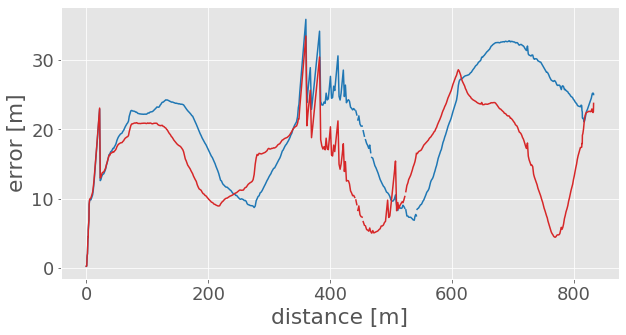

In [146]:
def calc_error():
    df_rtk_1Hz = df_rtk.asfreq(freq='1S', method='ffill')
    distance = np.cumsum(df_rtk_1Hz['speed[m/s]'])

    df_dr_1Hz = df_dr.asfreq(freq='1S', method='ffill')[-df_rtk_1Hz.shape[0]:]

    error_mag = calc_distance(df_rtk_1Hz['x'], df_rtk_1Hz['y'],
                          df_dr_1Hz['x_mag'], df_dr_1Hz['y_mag'])
    error_gyro = calc_distance(df_rtk_1Hz['x'], df_rtk_1Hz['y'],
                          df_dr_1Hz['x_gyro'], df_dr_1Hz['y_gyro'])

    return distance, error_mag, error_gyro

def plot_error():
    distance, error_mag, error_gyro = calc_error()

    fig = plt.figure(figsize=(10, 5))
    plt.plot(distance, error_mag[2:], color='tab:blue', label='DeadReckoning')
    plt.plot(distance, error_gyro[2:], color='tab:red', label='DeadReckoning')
    plt.xlabel('distance [m]')
    plt.ylabel('error [m]')

# 誤差表示
plot_error()

Text(0, 0.5, 'error [m]')

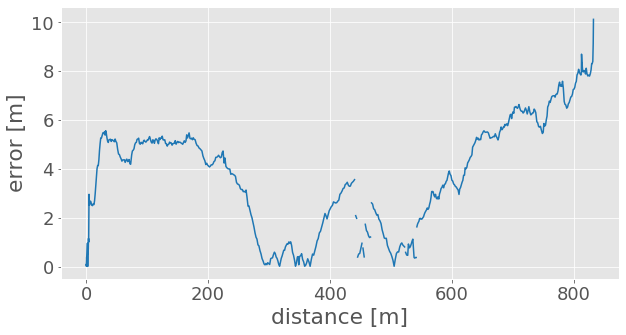

In [138]:
# 移動距離のみの誤差
df_rtk_1Hz = df_rtk.asfreq(freq='1S', method='ffill')
df_acc_1Hz = df_acc.asfreq(freq='1S', method='ffill')[-df_rtk_1Hz.shape[0]:]

distance_rtk = np.array(np.cumsum(df_rtk_1Hz['speed[m/s]']))
distance_nn = np.array(np.cumsum(df_acc_1Hz['speed[m/s]']))
error = np.abs(distance_rtk - distance_nn)
plt.figure(figsize=(10, 5))
# plt.plot(df_acc_1Hz.index, error/distance_rtk * 100)
plt.plot(distance_rtk, error, color='tab:blue')
plt.xlabel('distance [m]')
plt.ylabel('error [m]')
# plt.xlim(0, 30)
# plt.ylim(0, 2)

In [0]:
import matplotlib.animation as animation
import matplotlib.patches as patches

class AnimationMaker():
    def __init__(self):
        self.fig, ax = plt.subplots(figsize=(10, 10))

        self.l_rtk,  = ax.plot([], [], color='tab:gray',  label='rtk')
        self.l_gps,  = ax.plot([], [], color='tab:green', label='gps')
        self.l_mag,  = ax.plot([], [], color='tab:blue',  label='mag')
        self.l_gyro, = ax.plot([], [], color='tab:red',   label='gyro')

        self.c_rtk  = patches.Circle(
                            xy=(df_rtk['x'][0], df_rtk['y'][0]),
                            radius=1, fc='tab:gray')
        self.c_gps  = patches.Circle(
                            xy=(df_gps['x'][0], df_gps['y'][0]),
                            radius=1, fc='tab:green')
        self.c_mag  = patches.Circle(
                            xy=(df_dr['x_mag'][0], df_dr['y_mag'][0]),
                            radius=1, fc='tab:blue')
        self.c_gyro = patches.Circle(
                            xy=(df_dr['x_gyro'][0], df_dr['y_gyro'][0]),
                            radius=1, fc='tab:red')
        ax.add_patch(self.c_rtk)
        ax.add_patch(self.c_gps)
        ax.add_patch(self.c_mag)
        ax.add_patch(self.c_gyro)

        if len(locs) != 0:
            plt.scatter(locs[:, 0], locs[:, 1], color='tab:brown', s=150)

        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        blank_x = (max(df_rtk['x']) - min(df_rtk['x'])) * 0.2
        blank_y = (max(df_rtk['y']) - min(df_rtk['y'])) * 0.2
        ax.set_xlim(min(df_rtk['x']) - blank_x, max(df_rtk['x']) + blank_x)
        ax.set_ylim(min(df_rtk['y']) - blank_y, max(df_rtk['y']) + blank_y)
        ax.set_aspect('equal')
        ax.legend(loc='lower left')
        plt.subplots_adjust(left=0.08, right=0.97, bottom=0.04, top=0.97)

        self.ani = animation.FuncAnimation(self.fig, self._update,
                                           interval=100, frames=700)

    def _update(self, i):
        end = df_rtk.index[1] + datetime.timedelta(seconds=i)

        plt.title('t = {} [s]'.format(i))
        
        df_rtk_part = df_rtk[:end]
        df_gps_part = df_gps[:end]
        df_dr_part = df_dr[:end]

        self.l_rtk.set_data(df_rtk_part['x'], df_rtk_part['y'])
        self.l_gps.set_data(df_gps_part['x'], df_gps_part['y'])
        self.l_mag.set_data(df_dr_part['x_mag'], df_dr_part['y_mag'])
        self.l_gyro.set_data(df_dr_part['x_gyro'], df_dr_part['y_gyro'])
        
        self.c_rtk.set_center([df_rtk_part['x'][-1], df_rtk_part['y'][-1]])
        self.c_gps.set_center([df_gps_part['x'][-1], df_gps_part['y'][-1]])
        self.c_mag.set_center([df_dr_part['x_mag'][-1], 
                               df_dr_part['y_mag'][-1]])
        self.c_gyro.set_center([df_dr_part['x_gyro'][-1],
                                df_dr_part['y_gyro'][-1]])

In [0]:
# アニメーション作成
# ani_maker = AnimationMaker()

# from IPython.display import HTML
# HTML(ani_maker.ani.to_html5_video())

In [0]:
# アニメーション保存
# ani_maker.ani.save('graph/DeadReckoning.gif', writer='imagemagic')
# ani_maker.ani.save('graph/DeadReckoning.mp4', writer='ffmpeg')